In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path

import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent  # Go up 1 levels
pdpo_path = str(repo_root.absolute())
# Add repository root to path
sys.path.insert(0, pdpo_path)

print(sys.path)



['/work/Sebas/PDPO_jax', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python313.zip', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/lib-dynload', '', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages']


In [2]:

import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx

# Import our interpolation functions
from pdpo.models.builder import create_model

# Set random seeds for reproducibility
key = jrandom.PRNGKey(0)
np.random.seed(0)

jax.devices()
device = jax.devices('gpu')[0]


# Test with trained networks

In [3]:
from pdpo.data.toy_datasets import inf_train_gen
from pdpo.ode.solvers import MidpointSolver, EulerSolver
import pickle


In [4]:
from typing import Any
def move_to_device(pytree: Any, device) -> Any:
    """Recursively moves all JAX arrays in a PyTree to the specified device."""
    return jax.tree.map(lambda x: jax.device_put(x, device) if isinstance(x, jax.Array) else x, pytree)

In [5]:
name_exp0 = 'fm_std_gaussian_to_gaussian0_epoch_4999'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp0+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params0 = pickle.load(f)

name_exp1 = 'fm_std_gaussian_to_gaussian1_final'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp1+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params1 = pickle.load(f)    


# # args_arch = [2, 3, 4, 'softplus', True, jax_key]  # Example architecture args
args_arch = [model_params0['model_config']['input_dim'],
             model_params0['model_config']['num_layers'],
             model_params0['model_config']['hidden_dim'],
             model_params0['model_config']['activation'],
             model_params0['model_config']['time_varying'],
             key
            ]
key,subkey = jrandom.split(key)
print(args_arch)
# # Create MLP
vf = create_model(
    type='mlp',
    args_arch=args_arch
)


key,subkey = jrandom.split(key)

[2, 4, 128, 'softplus', True, Array([0, 0], dtype=uint32)]


In [6]:
vf.time_varying

True

In [7]:
state0 = model_params0['model_state']
state1 = model_params1['model_state']

# state0 = move_to_device(state0, device)
# state1 = move_to_device(state1, device)
bds = [state0, state1]

In [8]:
num_control_points = 3
t_controls = jnp.linspace(0,1,num_control_points)
s_query = jnp.linspace(0,1,30)


In [9]:
from pdpo.spline.builder import Assemble_spline

In [10]:
spline,t_controls = Assemble_spline(
    theta0 = state0,
    theta1 = state1,
    type_arch = 'mlp',
    arch = args_arch,
    data0= model_params0['data_config']['target_type'],
    data1= model_params1['data_config']['target_type'],
    number_of_knots= num_control_points,
    spline_type= 'cubic',
    device= device,
    prior_dist= model_params0['data_config']['source_type'],
    p= 2
)

In [11]:
from pdpo.spline.dynamics import gen_sample_trajectory

In [12]:
theta0,theta1  = spline.boundary_params
control_parameters = spline.control_points

all_params = [theta0] + control_parameters + [theta1]

In [13]:
sample_trajectory = gen_sample_trajectory(
    spline_state=spline,
    vf=vf,
    key=subkey,
    num_samples=1000,
    t_traj=s_query,
    solver=EulerSolver(),
)

key,subkey = jrandom.split(key)

/tmp/ipykernel_531896/2965285322.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


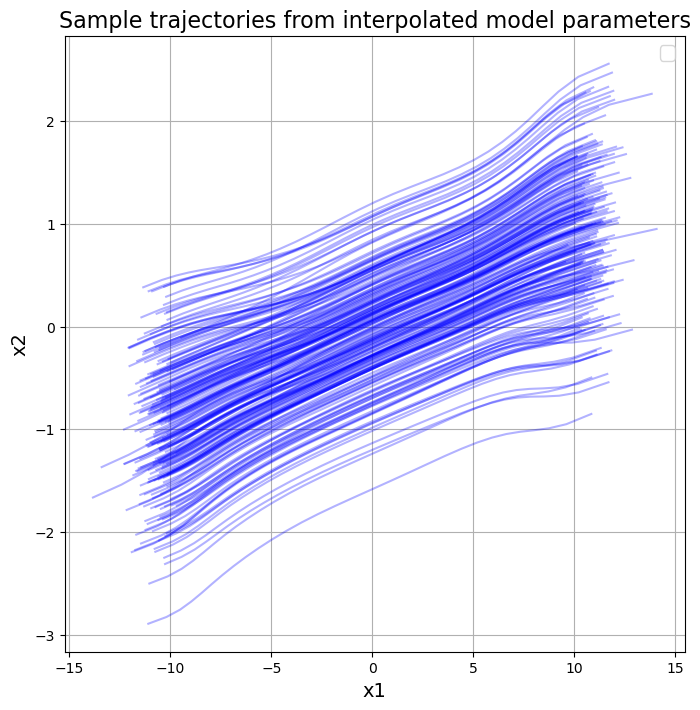

In [14]:
fig = plt.figure(figsize=(8, 8))    

for i in range(0,len(sample_trajectory),5):
    plt.plot(sample_trajectory[i,:,0],sample_trajectory[i,:,1],'b-',alpha=0.3)
plt.title('Sample trajectories from interpolated model parameters',fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()

In [15]:
sample_trajectory.shape

(1000, 30, 2)

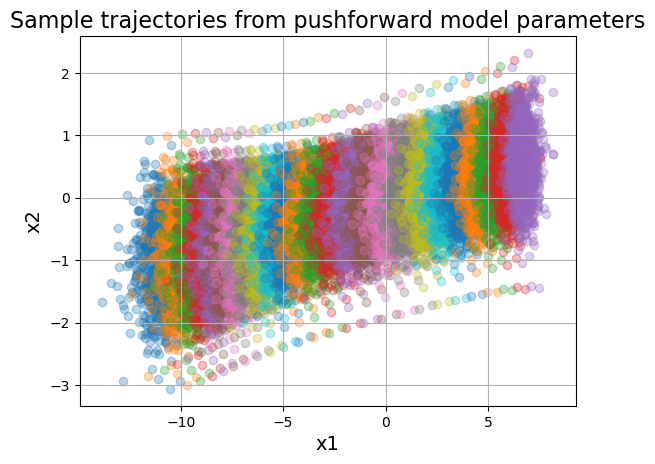

In [16]:
for i in range(25):
    plt.scatter(sample_trajectory[:,i,0],sample_trajectory[:,i,1],alpha=0.3)
plt.title('Sample trajectories from pushforward model parameters',fontsize=16)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()

In [17]:
from pdpo.energy_model.lagrangian import lagrangian
from pdpo.energy_model.potential import potential_energy

In [18]:
from pdpo.spline.types_interpolation import ProblemConfig
from dataclasses import replace

In [19]:
# spline = replace(spline.config.solver,EulerSolver )
spline.config = replace(spline.config,solver=EulerSolver())
#config_problem = replace(config_problem, splinestate=optimized_state)

In [20]:
potential = ["geodesic"]
coeff = [100.0]

config_problem = ProblemConfig(
    splinestate=spline,
    potential=potential,
    potential_coefficients=coeff
)


In [21]:
spline.config.solver

EulerSolver()

In [22]:
key,subkey = jrandom.split(key)

In [23]:
from pdpo.spline.path_optimization import optimize_path,geodesic_warmup
from pdpo.spline.optimization import optimize_path_with_boundaries


In [24]:
x0 = inf_train_gen(
    data_type = model_params0['data_config']['source_type'],
    key = subkey,
    batch_size = 1000
)

In [25]:
optimized_state,history = geodesic_warmup(
    problem_config=config_problem,
    key = subkey,
    epochs = 10,
    learning_rate=1e-3,
    batch_size=100,
    use_adjoint=False
)

config_problem = replace(config_problem, splinestate=optimized_state)

In [26]:
sample_trajectory = gen_sample_trajectory(
    spline_state=optimized_state,
    vf=vf,
    key=subkey,
    num_samples=1000,
    t_traj=s_query,
    solver=EulerSolver(),
)

key,subkey = jrandom.split(key)

/tmp/ipykernel_531896/2965285322.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


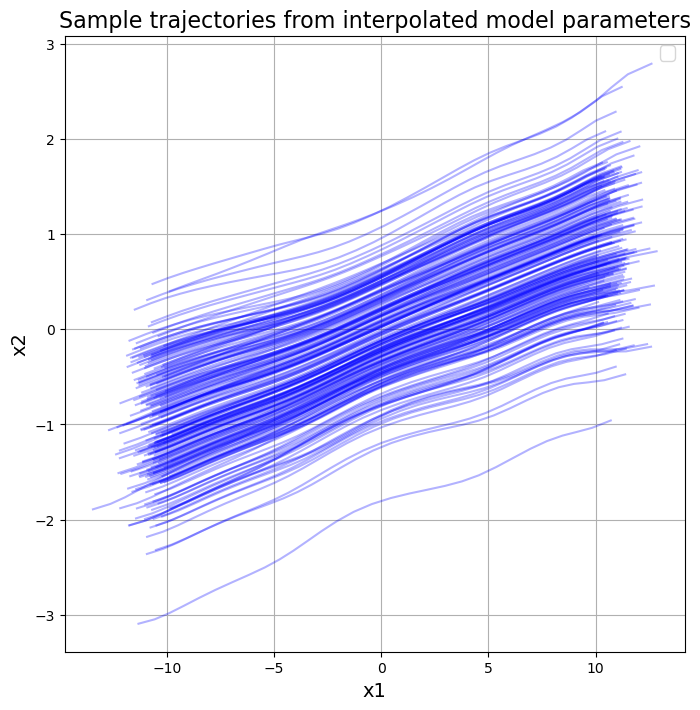

In [27]:
fig = plt.figure(figsize=(8, 8))    

for i in range(0,len(sample_trajectory),5):
    plt.plot(sample_trajectory[i,:,0],sample_trajectory[i,:,1],'b-',alpha=0.3)
plt.title('Sample trajectories from interpolated model parameters',fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()

In [28]:
optimized_state,history = optimize_path_with_boundaries(
    problem_config=config_problem,
    boundary_method_type='FM',
    key = subkey,
    path_epochs = 10,
    boundary_epochs= 10,
    alternating_iterations= 2,
    batch_size=5000,
    use_adjoint = False
)

Completed boundary optimization iteration 1/2
Completed boundary optimization iteration 2/2


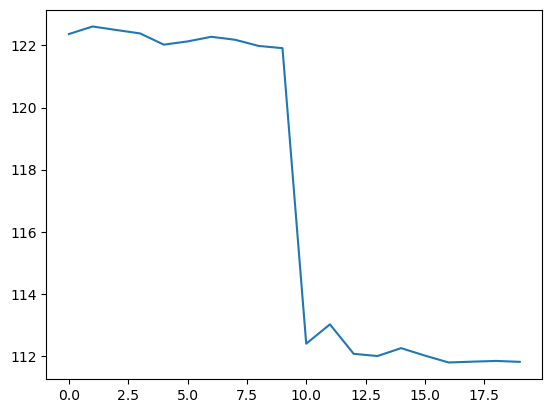

In [29]:
plt.plot(history['path_losses'])

In [30]:
config_problem = replace(config_problem, splinestate=optimized_state)
key,subkey = jrandom.split(key)

In [31]:


# optimized_state,final_opt_state,history = optimize_path(
#     problem_config = config_problem,
#     key = subkey,
#     epochs = 3,
#     learning_rate = 1e-3,
#     x0 = x0
# )

# config_problem = replace(config_problem, splinestate=optimized_state)

# key,subkey = jrandom.split(key)

In [32]:
# fig = plt.figure(figsize=(15, 8))
# plt.plot(history.lagrangian, label='Lagrangian')
# plt.plot(history.kinetic, label='Kinetic Energy')
# plt.plot(history.potential, label='Potential Energy')
# plt.xlabel('Epochs')
# plt.ylabel('Energy')
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)
# plt.title('Energy Evolution During Optimization', fontsize=18)
# plt.grid()
# plt.show()

In [33]:

time_trajectory = jnp.linspace(0, 1, 50)
num_samples = 4000
key,subkey = jrandom.split(key)
# z = 
x0 = inf_train_gen(
    data_type = model_params0['data_config']['source_type'],
    key = subkey,
    batch_size = num_samples
)
sample_trajectory_opt = gen_sample_trajectory(
    spline_state=optimized_state,
    vf=vf,
    x0=x0,
    key=subkey,
    num_samples=num_samples,
    t_traj=time_trajectory,
    solver=EulerSolver(),
)

sample_trajectory_no_opt = gen_sample_trajectory(
    spline_state=spline,
    vf=vf,
    x0=x0,
    key=subkey,
    num_samples=num_samples,
    t_traj=time_trajectory,
    solver=EulerSolver(),
)


key,subkey = jrandom.split(key)




In [34]:
# Compute lagrangians

lagrangian_opt = lagrangian(samples_path=sample_trajectory_opt,
                            times_path=time_trajectory,
                            problem_config=config_problem,
                            key = subkey)
lagrangian_no_opt = lagrangian(samples_path=sample_trajectory_no_opt,
                               times_path=time_trajectory,
                               problem_config=config_problem, 
                               key= subkey)

key,subkey = jrandom.split(key)

print(f"Lagrangian (Optimized): {lagrangian_opt}")
print(f"Lagrangian (No Optimization): {lagrangian_no_opt}")

Lagrangian (Optimized): (Array(113.96093, dtype=float32), Array(113.96093, dtype=float32), Array(0., dtype=float32))
Lagrangian (No Optimization): (Array(127.65152, dtype=float32), Array(127.65152, dtype=float32), Array(0., dtype=float32))


In [35]:
x0 = inf_train_gen(
    data_type = model_params0['data_config']['target_type'],
    key = subkey,
    batch_size = 1000
)

x1 = inf_train_gen(
    data_type = model_params1['data_config']['target_type'],
    key = subkey,
    batch_size = 1000
)


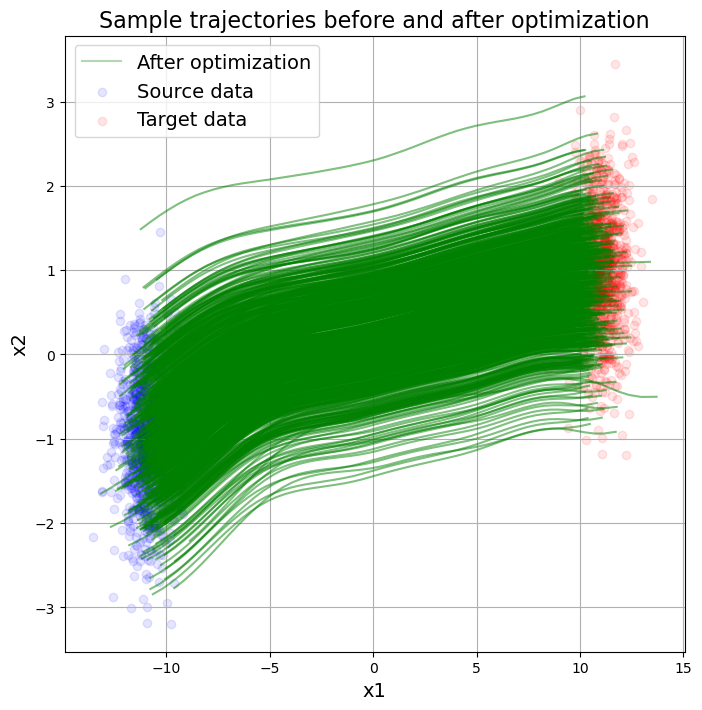

In [36]:
fig = plt.figure(figsize=(8, 8))

# plt.plot(sample_trajectory_no_opt[0,:,0],sample_trajectory_no_opt[0,:,1],'y-',label='Before optimization',alpha=0.3)
plt.plot(sample_trajectory_opt[0,:,0],sample_trajectory_opt[0,:,1],'g-',label='After optimization',alpha=0.3)

for i in range(1,len(sample_trajectory_no_opt),5):
    # plt.plot(sample_trajectory_no_opt[i,:,0],sample_trajectory_no_opt[i,:,1],'y-',alpha=0.5)
    plt.plot(sample_trajectory_opt[i,:,0],sample_trajectory_opt[i,:,1],'g-',alpha=0.5)


plt.scatter(x0[:,0],x0[:,1],c='blue',label='Source data',alpha=0.1)
plt.scatter(x1[:,0],x1[:,1],c='red',label='Target data',alpha=0.1)

plt.title('Sample trajectories before and after optimization',fontsize=16)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

/tmp/ipykernel_531896/1417063170.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


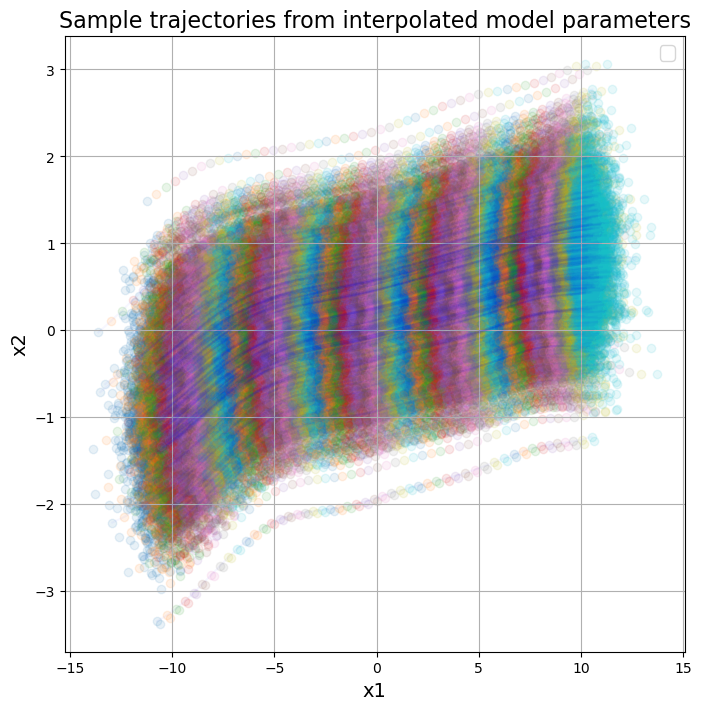

In [37]:
fig = plt.figure(figsize=(8, 8))    

for i in range(len(time_trajectory)):
    plt.scatter(sample_trajectory_opt[:,i,0],sample_trajectory_opt[:,i,1],alpha=0.1)

for i in range(0,len(sample_trajectory_opt),10):
    plt.plot(sample_trajectory_opt[i,:,0],sample_trajectory_opt[i,:,1],'b-',alpha=0.03)



plt.title('Sample trajectories from interpolated model parameters',fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.grid()
plt.show()